In [3]:
import gymnasium as gym
env = gym.make('CartPole-v1')

In [4]:
import mlflow

# connect mlflow client to the mlflow server that runs on localhost:5000
MLFLOW_SERVER_URI = 'http://localhost:5000'
mlflow.set_tracking_uri(str(MLFLOW_SERVER_URI))

EXPERIMENT_NAME = 'DQN_24_03_03'
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/511816369638665683', creation_time=1709482697874, experiment_id='511816369638665683', last_update_time=1709482697874, lifecycle_stage='active', name='DQN_24_03_03', tags={}>

In [5]:
import optuna

from config import OPTUNA_DB

study = optuna.create_study(
    study_name=EXPERIMENT_NAME,
    direction='maximize',
    load_if_exists=True,
    storage=f'sqlite:///{OPTUNA_DB}'
)

optuna.logging.set_verbosity(optuna.logging.ERROR)

[I 2024-03-03 16:04:20,565] Using an existing study with name 'DQN_24_03_03' instead of creating a new one.


In [10]:
from optimize_hyperparameters import objective

#A ideia é treinar cada conjunto de hiperparâmetros por 200 épocas e 
# avaliar por 1000, a função retorna a recompensa média dessas 1000 iterações


# we define a lambda function because study.optimize()
# expect the objective function to have only 1 input
# (trial), while our objective function hast 2 extra
# inputs I defined to add flexibility to the script
func = lambda trial: objective(trial,
                               force_linear_model=False,
                               n_episodes_to_train=300)

class CheckHyperparamMeanRewardThreshold:
    def __init__(self, reward_threshold: float):
        self.reward_threshold = reward_threshold

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value is not None and trial.value >= self.reward_threshold:
            print((f'Stopping hyperparameter search because trial.value ({trial.value}) '
                   f'hit threshold ({self.reward_threshold})'))
            study.stop()

# Stop hyperparameter search when we hit a perfect mean reward of 500
hyperparam_search_stop_callback = CheckHyperparamMeanRewardThreshold(500.0)

study.optimize(func, n_trials=int(1e4), callbacks=[hyperparam_search_stop_callback], show_progress_bar=True)
# Existe um puta problema relacionado ao como representar redes com múltiplas camadas, não estou com saco pra resolver isso agora
# mas saiba que existe e que pra resolver precisa dissecar o dicionário de parâmetros que o optuna usa


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopping hyperparameter search because trial.value (500.0) hit threshold (500.0)


In [6]:
import os
from q_agent import QAgent
from config import SAVED_AGENTS_DIR

diretorio_pai = SAVED_AGENTS_DIR / 'CartPole-v1'

# Lista de todos os diretórios no diretório_pai
diretorios = [d for d in os.listdir(diretorio_pai) if os.path.isdir(os.path.join(diretorio_pai, d))]

# Função para obter o tempo de criação de um diretório
def obter_tempo_criacao(diretorio):
    caminho_completo = os.path.join(diretorio_pai, diretorio)
    return os.path.getctime(caminho_completo)

# Encontrar o último diretório criado
ultimo_diretorio = max(diretorios, key=obter_tempo_criacao)

# Caminho completo para o último diretório criado
path_to_saved_model = diretorio_pai / str(ultimo_diretorio)

agent = QAgent.load_from_disk(env, path_to_saved_model)

In [7]:
from loops import evaluate
rewards, steps = evaluate(
    agent, env,
    n_episodes=1000,
    epsilon=0.00
)

In [8]:
import numpy as np
reward_avg = np.array(rewards).mean()
reward_std = np.array(rewards).std()
print(f'Reward average {reward_avg:.2f}, std {reward_std:.2f}')

Reward average 500.00, std 0.00


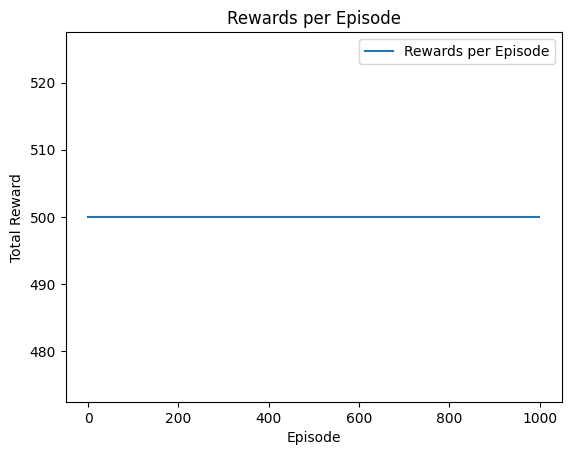

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
plt.plot(rewards, label='Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.legend()
plt.show()

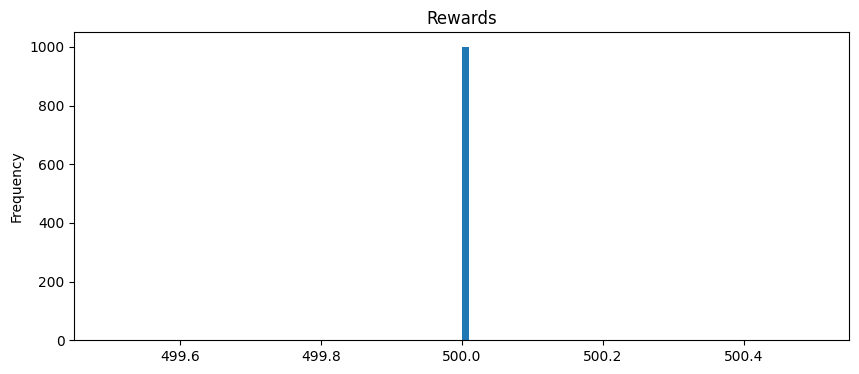

In [10]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")    
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()

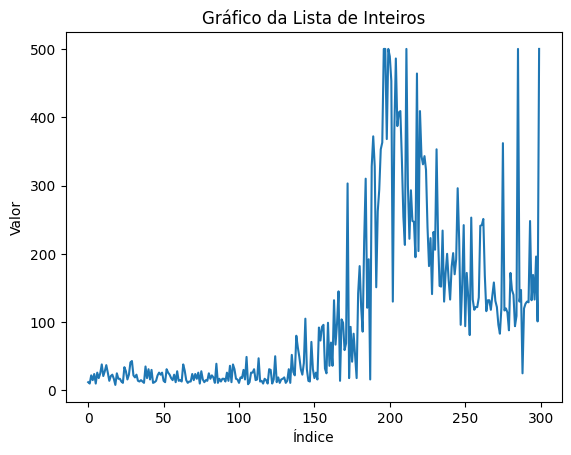

In [11]:
import pickle
path = os.path.join(path_to_saved_model, 'rewards.pkl')

with open(path, 'rb') as file:
    lista_de_inteiros = pickle.load(file)

# Plotando um gráfico simples
plt.plot(lista_de_inteiros) 
plt.title('Gráfico da Lista de Inteiros')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.show()

In [12]:
# Teste pra mostrar que essa porra funciona
env = gym.make('CartPole-v1', render_mode = 'human')
state = env.reset()[0]
done = False
while not done:
    action = agent.act(state, epsilon=0)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    state = next_state


In [19]:
agent.hparams

{'learning_rate': 0.0004440810461691137,
 'discount_factor': 0.9,
 'batch_size': 32,
 'memory_size': 10000,
 'freq_steps_update_target': 10,
 'n_steps_warm_up_memory': 1000,
 'freq_steps_train': 16,
 'n_gradient_steps': 16,
 'nn_hidden_layers': 128,
 'max_grad_norm': 1,
 'normalize_state': True,
 'epsilon_start': 0.9,
 'epsilon_end': 0.20994844340303626,
 'steps_epsilon_decay': 10000}

In [13]:
# 10 de 10 essa função, obg GPT
from torchinfo import summary
summary(agent.q_net, input_size=(1,4))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Linear: 1-1                            [1, 128]                  640
├─ReLU: 1-2                              [1, 128]                  --
├─Linear: 1-3                            [1, 2]                    258
Total params: 898
Trainable params: 898
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00